# Custom likelihoods

Sometimes we want to be able to perform Bayesian inference on models which have not been implemented in probabilistic programming languages like `pymc3`. In these cases, we need to be able to sample from models for which we can write down the analytic log-likelihood ourselves.

Tip: See `distribution.py` and `dist_math.py` in `~/anaconda3/lib/python3.6/site-packages/pymc3/distributions` for examples of how to implement custom likelihoods.

Author: Juvid Aryaman

In [1]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import mystyle.sty as sty # see https://github.com/jaryaman/mystyle 

In [2]:
sty.reset_plots()

In [3]:
from pymc3.distributions.dist_math import binomln, logpow
import theano.tensor as tt

Suppose that we would like to sample from the following likelihood, which is the solution for a pure-birth process:

$$P(i|\lambda t, n_0) = \begin{pmatrix}i-1\\
n_0 - 1
\end{pmatrix} e^{-\lambda n_0 t} (1- e^{-\lambda t})^{i - n_0}$$

which is a negative binomial distribution.

Define the log-likelihood for the model:

In [4]:
def logp_neg_binom(n0, lam_t, i):
    '''
    Log-likelihood for pure-birth process
    '''
    return binomln(i-1, n0-1) -lam_t*n0 + logpow(1 - tt.exp(-lam_t), i - n0)

Given values for $n_0$ and $i$, compute the maximum likelihood estimate for $\lambda t$. Note that the maximum likelihood is equivalent to the maximum a posteriori estimate given a uniform prior for the parameter, and also assuming that the prior has support over the maximum likelihood estimate.

Compile the model

In [5]:
n0 = 50
i = 100
with pm.Model() as neg_binom_model:
    lam_t = pm.Uniform('lam-t', 0, 100)
    ll = pm.DensityDist('ll', logp_neg_binom, observed=dict(n0=n0,lam_t=lam_t,i=i))

Find the MAP

In [6]:
map_estimate = pm.find_MAP(model=neg_binom_model)

/home/juvid/anaconda3/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -2,438.5, ||grad|| = 1,250: 100%|██████████| 9/9 [00:00<00:00, 1277.32it/s]


In [7]:
map_est = map_estimate['lam-t']
map_est

array(0.6931472)

In [8]:
n0*np.exp(map_est.flatten()[0])

100.00000211832443

So the maximum likelihood estimate recovers the true value of `i` quite accurately in this case

We can also do full Bayesian inference:

In [9]:
with neg_binom_model:
    trace = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [lam-t]
Sampling 3 chains: 100%|██████████| 16500/16500 [00:04<00:00, 3335.46draws/s]
The acceptance probability does not match the target. It is 0.8806301143115592, but should be close to 0.8. Try to increase the number of tuning steps.


/home/juvid/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


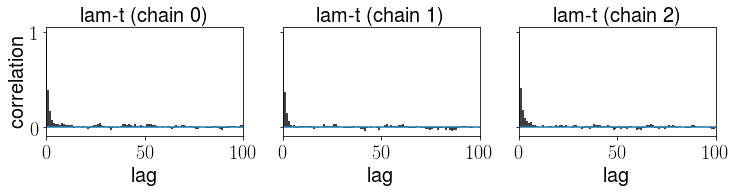

In [10]:
pm.plots.autocorrplot(trace);

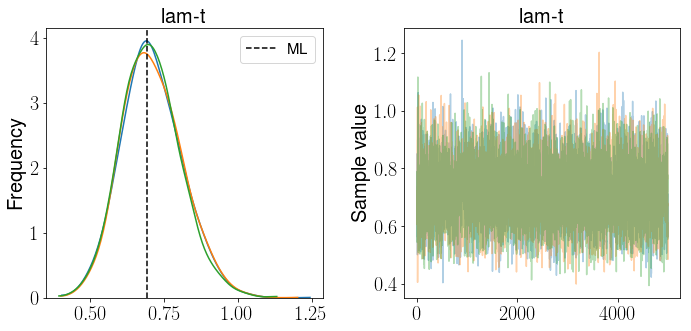

In [26]:
fig, axs = plt.subplots(1,2, figsize=(2*5,5))
pm.plots.traceplot(trace, ax=np.reshape(axs, (1,2)));
axs[0].plot(map_est.flatten()[0]*np.ones(50), np.linspace(0,4.3),'--k', label='ML')
axs[0].legend();